In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
from keras.datasets import fashion_mnist

# Про dataset `fashion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [13]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
input_shape = (28, 28, 1)

TRAINING = (
    False  # Константа, якак визначає. чи треба навчати, чи використовувати модель
)

# Підготовка навчального та тестового наборів

In [14]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Побудова архітектури нейронної мережі (моделі)


## Деякий опис використовуваних шарів

```python
keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1))
```

Тут вказано 32 фільтри з ядрами 3х3 пікселя кожен. Потім, параметр `padding='same'` означає, що вихідна карта ознак на кожному каналі має бути тією самою розмірністю, що й вихідне зображення, тобто 28х28 елементів. Фактично, це означає додавання значень на кордонах двовимірних даних (загалом нулів), щоб центр ядра фільтра міг розміщуватися над граничними елементами:

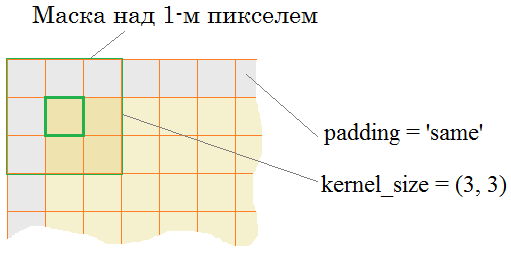

Останні два параметри - функція активації ReLu і формат вхідних даних у вигляді зображень 28х28 пікселів з одним колірним каналом (градації сірого).

Наступний шар відповідно до концепції `CNN` має укрупнювати масштаб отриманих ознак. Для цього найчастіше використовується операція `MaxPooling`:


```python
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
```

Тут `pool_size` - розмір вікна, в якому обирається максимальне значення; strides - крок сканування за координатами площини; `padding='valid'`` - не додавати нульових значень на кордонах (відповідно рамка не зміщується за межі поля ознак); `data_format`` - формат вхідних даних:

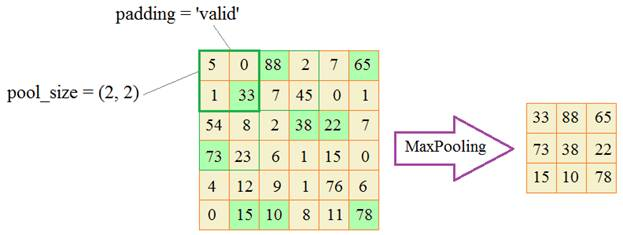

In [15]:
# Побудова архітектури моделі
keras.utils.set_random_seed(42)


def build_model():
    model = keras.Sequential()
    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(64, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(128, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(256, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Activation("elu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))
    model.add(layers.Activation("softmax"))
    return model

# Створення моделі

In [20]:
model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, ema_momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 28, 28, 1)         4         
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                      

# Завантаження вагів, якщо вони є в файлі

In [21]:
if os.path.exists("weights.h5"):
    model.load_weights("weights.h5")
    print("Завантажено збережені ваги.")
else:
    print("Ваги не знайдено, починаємо навчання заново.")

Завантажено збережені ваги.


# Навчання моделі

Тренування відбувається доволі довго, тому використаємо колбекки збереження вагів натренованої моделі [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) та  колбек ранньої зупинки [EarlyStopping](https://keras.io/api/callbacks/early_stopping/). Ваги будемо зберігати в файл `weights.h5`.

*Формат файлу `HDF5` (`Hierarchical Data Format version 5`) забезпечує ефективне і зручне зберігання великих об'ємів числових даних,зокркма ваги моделей нейронних мереж.*


In [22]:
if TRAINING:
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3,
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint = ModelCheckpoint("weights.h5", monitor="val_loss", save_best_only=True)

    early_stopping = EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.0001,
        patience=10,
        mode="auto",
        baseline=0.93,
        restore_best_weights=False,
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=10,
        steps_per_epoch=60,
        callbacks=[checkpoint, early_stopping],
        validation_data=(x_test, y_test),
    )

    # Оцінка моделі на тестовому наборі даних
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print(f"\nТочність на тестовому наборі: {test_accuracy:.2f}")

# Перевірка результатів

In [23]:
predictions = model.predict(x_test)
if not TRAINING:
    _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nТочність на тестовому наборі: {test_accuracy:.2f}")

313/313 [==============================] - 17s 53ms/step

Точність на тестовому наборі: 0.92


# Візуалізація передбачень

In [40]:
number_of_images = 40  # розмр вибірки зображень

In [42]:
# Знайдемо seed при якому розпізнані всі зображення із рандомної вибірки
for seed in range(1, 100, 1):
    np.random.seed(seed)
    count = 0

    for sample_index in range(number_of_images):
        sample_index = np.random.choice(10000)
        prob = predictions[sample_index]
        predicted_label = np.argmax(prob)

        if predicted_label == y_test[sample_index]:
            count += 1

    accuracy = count / number_of_images
    if int(accuracy) == 1:
        print(f"Seed {seed}: {accuracy * 100:.0f}% accuracy")


Seed 41: 100% accuracy
Seed 63: 100% accuracy
Seed 72: 100% accuracy
Seed 84: 100% accuracy
Seed 86: 100% accuracy


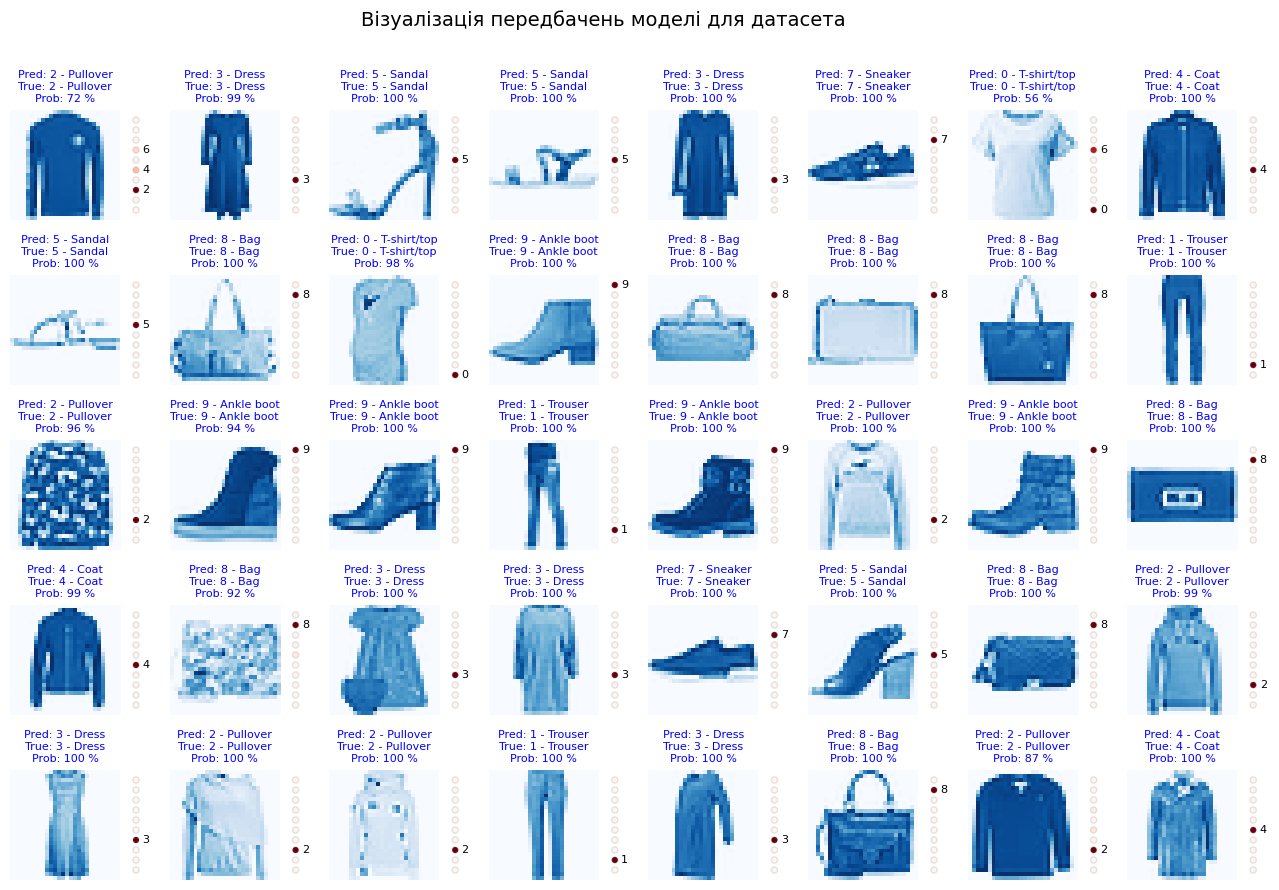

In [43]:
f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

f.suptitle("Візуалізація передбачень моделі для датасета", fontsize=14)

np.random.seed(41)
for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = "blue"
        cmap = "Blues"
    else:
        color = "red"
        cmap = "Reds"

    ax[axes_index // 8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index // 8, axes_index % 8].axis("off")
    ax[axes_index // 8, axes_index % 8].set_title(
        f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label} - {class_labels.get(true_label)}\nProb: {prob.max()*100:.0f} %",
        fontsize=8,
        color=color,
    )

    inset_ax = f.add_axes(
        [
            ax[axes_index // 8, axes_index % 8].get_position().x1,
            ax[axes_index // 8, axes_index % 8].get_position().y0,
            0.02,
            ax[axes_index // 8, axes_index % 8].get_position().height,
        ]
    )

    classes = np.arange(len(class_labels))
    inset_ax.scatter(
        np.ones(10) * 0.5,
        classes,
        s=20,
        c=prob,
        cmap="Reds",
        marker="o",
        edgecolor=(0.5, 0.5, 0.5, 0.2),
        linewidths=1,
    )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis("off")
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f"{i}", fontsize=8, verticalalignment="center")

plt.show()

На візуалізації представлені зображення із тестової вибірки. В синіх тонах - розпізнані правильно, в червоних - неправильно. Праворуч наведена шкала (фактично це нейрони вихідного шару), де колір пропорційний "ймовірності" розпізнавання, також праворуч наведені мітки класів (номер нейрона), якщо їх ймовірність більше 10 %.

# Висновки


В результаті використання згорткової нейронної мережі вдалось досягти точності 0.92. В попередньому завдання для повнозєязної нейронної мережі вдалось досягти точності лише 0.89. 

На рандомно вибраних сорока зображенняхвдається часто побачити такі вибірки, де не правильно розпізнано всього два зображення, ба навіть можна знайти правильно розпізнані всі зображення.

Отже, згорткові нейронні мережі є більш ефективними для обробки зображень.